# ARN - PW3

Auteurs : Rémi Ançay & Lucas Charbonnier

In [113]:
import pandas as pd

# chargement des données

data_folder = "../data/lab3/"

mouse_data_1 = pd.read_csv(data_folder + "EEG_mouse_data_1.csv")
mouse_data_2 = pd.read_csv(data_folder + "EEG_mouse_data_2.csv")

mouse_data = pd.concat([mouse_data_1, mouse_data_2])

test_data = pd.read_csv(data_folder + "EEG_mouse_data_test.csv")

In [114]:
# sélection des features qui seront gardées
from itertools import chain

print(len(mouse_data.columns))

def discard_unwanted_frequencies(dataframe):
    discarded_frequencies = range(26,102) #chain(range(16, 45),range(55,102))
    for freq in discarded_frequencies:
        col_name = "amplitude_around_" + str(freq) + "_Hertz"
        dataframe = dataframe.drop(columns=col_name)
    return dataframe

mouse_data = discard_unwanted_frequencies(mouse_data)
test_data = discard_unwanted_frequencies(test_data)

# we now have 26 columns : 25 features (frequencies) and 1 result column
print(len(mouse_data.columns))

102
26


In [115]:
from sklearn.preprocessing import StandardScaler

# normalisation du dataset
scaler = StandardScaler()
mouse_data.iloc[:,1:] = scaler.fit_transform(mouse_data.iloc[:,1:])
test_data.iloc[:,1:] = scaler.fit_transform(test_data.iloc[:,1:])

In [116]:
#!pip install keras
#!pip install tensorflow

In [117]:
import keras
from keras import layers
from sklearn.model_selection import KFold

# creations de folds pour la validation croisée

N_FOLDS = 3

keras.utils.set_random_seed(123)
kf = KFold(n_splits=N_FOLDS, shuffle=True)

# taille totale et taille des folds
for i,(train_index, test_index) in enumerate(kf.split(mouse_data)):
    print(train_index, test_index)

[    0     2     3 ... 40860 40861 40862] [    1     8    15 ... 40854 40856 40857]
[    0     1     4 ... 40859 40860 40862] [    2     3     5 ... 40855 40858 40861]
[    1     2     3 ... 40857 40858 40861] [    0     4     6 ... 40859 40860 40862]


In [118]:
MODEL_LAYERS = [3]
ACTIVATION_FCTN = "sigmoid"
LEARNING_RATE = 0.01
MOMENTUM = 0.9

def create_model():

    layers = [keras.Input((25,))]
    for layer in MODEL_LAYERS:
            layers.append(keras.layers.Dense(layer, activation=ACTIVATION_FCTN))
    layers.append(keras.layers.Dense(1,activation=ACTIVATION_FCTN))

    mlp = keras.Sequential(layers)

    mlp.compile(
        optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
        loss="mse"
    )
    return mlp

model = create_model()

model.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_151 (Dense)               │ (None, 3)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82 (328.00 B)

 Trainable params: 82 (328.00 B)

 Non-trainable params: 0 (0.00 B)

In [119]:
input_data = mouse_data.drop(columns='state')
output_data = mouse_data['state']

output_data = output_data.replace('w', 1)
output_data = output_data.replace('n', 0)
output_data = output_data.replace('r', 0)

history_list = []
trained_mlp = []

for i,(train_idx, test_idx) in enumerate(kf.split(mouse_data)) :
    mlp = create_model()
    history = mlp.fit(
        x=input_data.iloc[train_idx], y=output_data.iloc[train_idx],
        validation_data=(input_data.iloc[test_idx], output_data.iloc[test_idx]),
        epochs=20
    )

    history_list.append(history)
    trained_mlp.append(mlp)


Epoch 1/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1874 - val_loss: 0.0996
Epoch 2/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - loss: 0.0989 - val_loss: 0.0885
Epoch 3/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0911 - val_loss: 0.0868
Epoch 4/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 0.0894 - val_loss: 0.0865
Epoch 5/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0889 - val_loss: 0.0865
Epoch 6/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - loss: 0.0887 - val_loss: 0.0865
Epoch 7/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0885 - val_loss: 0.0865
Epoch 8/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - loss: 0.0884 - val_loss: 0.0865
Epoch 9/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0883 - val_loss: 0.0864
Epoch 10/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 0.0883 - val_loss: 0.0864
Epoch 11/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - loss: 0.0882 - val_loss: 0.0864
Epoch 12/20
852/852 ━━━━━━━━━━━━━━━━━━━━

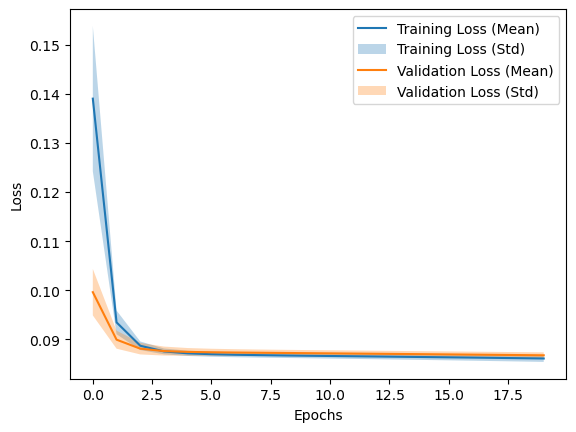

In [120]:
import numpy as np
import matplotlib.pyplot as pl

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

Après avoir testé plusieurs hyper-paramètres (nombre de couches, neurones par couche, fonction d'activation), nous avons trouvé qu'utiliser un sigmoïde avec une seule hidden-layer de 3 neurones donnait les meilleures résultats.

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


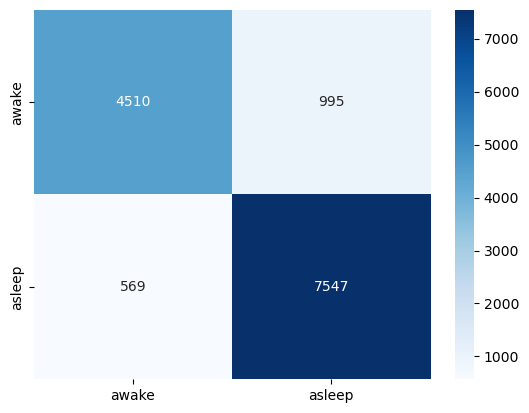

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


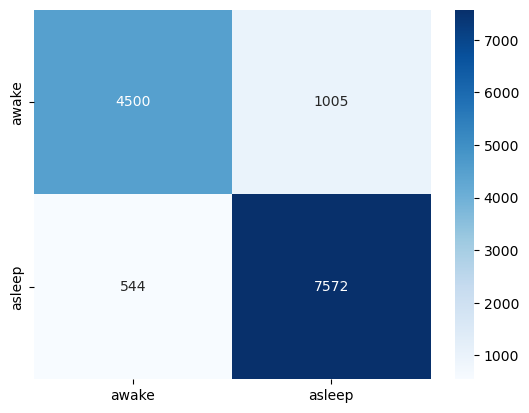

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


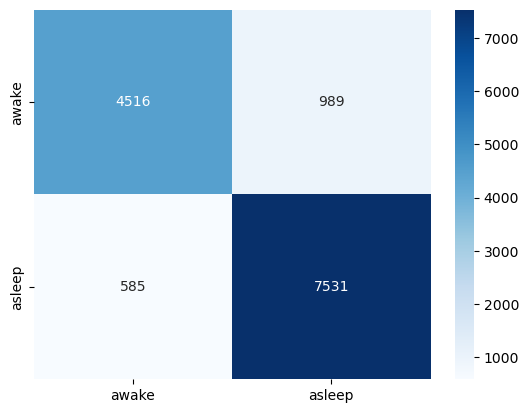

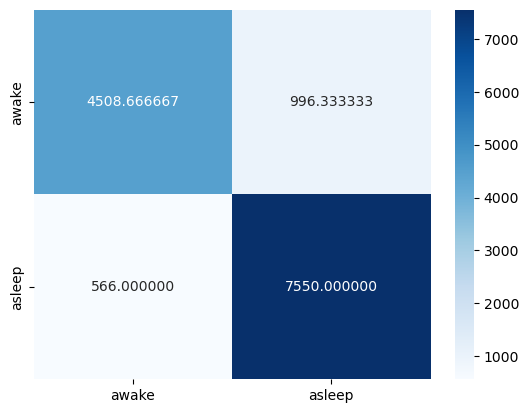

In [121]:
#plot all the confusion matrices and the mean confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrices = []

for i, mlp in enumerate(trained_mlp):
    y_pred = mlp.predict(input_data.iloc[test_idx])
    y_pred = np.round(y_pred)
    cm = confusion_matrix(output_data.iloc[test_idx], y_pred)
    confusion_matrices.append(cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["awake", "asleep"], yticklabels=["awake", "asleep"])
    pl.show()

mean_cm = np.mean(confusion_matrices, axis=0)
sns.heatmap(mean_cm, annot=True, fmt="f", cmap="Blues", xticklabels=["awake", "asleep"], yticklabels=["awake", "asleep"])
pl.show()